## Testing the python implementation of the structure functions

In [1]:
import numpy as np
from matplotlib import pylab as pl

Load in the fortran structure functions

In [2]:
import WD, WM, WMP2, WP1, WP2, WS1, WS2, WS1D
print WD.__doc__

This module 'WD' is auto-generated with f2py (version:2).
Functions:
  wd = calcwd(i,j,y,target)
.


Load in the python structure functions

In [3]:
from Wfunctions_python import WD as pyWD
from Wfunctions_python import WM as pyWM
from Wfunctions_python import WMP2 as pyWMP2
from Wfunctions_python import WP1 as pyWP1
from Wfunctions_python import WP2 as pyWP2
from Wfunctions_python import WS1 as pyWS1
from Wfunctions_python import WS2 as pyWS2
from Wfunctions_python import WS1D as pyWS1D

In [4]:
#Define a function which tests the structure functions
target_list = np.loadtxt("../Nuclei.txt", usecols=(0,), dtype='string')
A_list = np.loadtxt("../Nuclei.txt", usecols=(1,))
Avals = dict(zip(target_list, A_list))

Function to plot some of the structure functions for comparison:

In [5]:
def Plot_WM(target):
    #Range of recoil energies to test
    E_list = np.logspace(-3, 2, 100)
    
    #Calculate sensible 'y' values for the given target
    A = Avals[target]
    amu = 931.5e3 # keV
    q1 = np.sqrt(2*A*amu*E_list)

    #Recoil momentum over nucleon mass
    qr = q1/amu
    
    # Required for form factors
    q2 = q1*(1e-12/1.97e-7)
    b = np.sqrt(41.467/(45*A**(-1.0/3.0) - 25*A**(-2.0/3.0)))
    y = (q2*b/2)**2
    
    W_test_f = np.zeros((2,2,len(E_list)))
    W_test_py = np.zeros((2,2,len(E_list)))
    
    pl.figure(figsize=(7,5))
    
    cols = [['r','g'], ['b','c']]
    
    for i in range(2):
        for j in range(2):
            W_test_f[i,j,:] = np.vectorize(WM.calcwm)(i,j,y,target)
            W_test_py[i,j,:] = pyWM.calcWM(i,j,y,target)
            ls = '-'
        
            pl.semilogx(E_list,W_test_py[i,j,:], linestyle='-', label=str(i)+str(j), color =cols[i][j], alpha=0.5)
            pl.semilogx(E_list,W_test_f[i,j,:], linestyle='--',color =cols[i][j])
    pl.semilogx(0,0, 'k-', label='Python')
    pl.semilogx(0,0, 'k--', label='Fortran')
    pl.legend(loc="best")
    pl.xlabel(r'$E_R$ [keV]')
    pl.ylabel(r'$W_M(E_R)$')
    pl.title(target)
    pl.show()
            

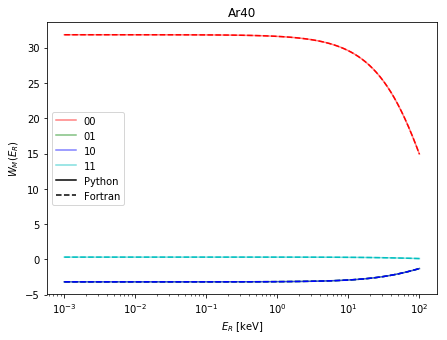

In [6]:
Plot_WM("Ar40")

Function to carefully test all the structure functions (for a given target)

In [30]:
def Compare_W(target, err_tol=1e-4):
    
    print "   Testing python and fortran W functions for target", target,"..."
    
    found_discrepancy = False
    
    #Range of recoil energies to test
    E_list = np.logspace(-3, 2, 1000)
    
    #Calculate sensible 'y' values for the given target
    A = Avals[target]
    amu = 931.5e3 # keV
    q1 = np.sqrt(2*A*amu*E_list)

    #Recoil momentum over nucleon mass
    qr = q1/amu
    
    # Required for form factors
    q2 = q1*(1e-12/1.97e-7)
    b = np.sqrt(41.467/(45*A**(-1.0/3.0) - 25*A**(-2.0/3.0)))
    y = (q2*b/2)**2
    
    
    fortran_funcs = [WM.calcwm, WD.calcwd, WMP2.calcwmp2, WP1.calcwp1, WP2.calcwp2, WS1.calcws1, WS2.calcws2, WS1D.calcws1d]
    python_funcs = [pyWM.calcWM, pyWD.calcWD, pyWMP2.calcWMP2, pyWP1.calcWP1, pyWP2.calcWP2, pyWS1.calcWS1, pyWS2.calcWS2, pyWS1D.calcWS1D]
    
    for fort_fun, py_fun in zip(fortran_funcs, python_funcs):
        
        W_test_f = np.zeros(len(E_list))
        W_test_py = np.zeros(len(E_list))
    
        #print py_fun.__name__
        for i in range(2):
            for j in range(2):
                W_test_f = np.vectorize(fort_fun)(i,j,y,target)
                W_test_py = py_fun(i,j,y,target)

                norm = np.trapz(W_test_f, E_list)/(np.max(E_list) - np.min(E_list))
                
                #Test the values you calculate using the 2 codes
                error = np.sqrt((W_test_f - W_test_py)**2/norm**2)
                if np.any(error > err_tol):
                    found_discrepancy = True
                    print "   Discrepancy found in ", py_fun.__name__, " for i = ", i, ", j = ", j
                    
                    #print W_test_py
                    #print W_test_f
                    
                    pl.figure(figsize=(7,5))
                    pl.loglog(E_list,np.abs(W_test_py), linestyle='-', alpha=0.5, label='Python')
                    pl.loglog(E_list,np.abs(W_test_f), linestyle='--',label='Fortran')
                    #pl.semilogx(E_list,error, linestyle='--',label='Fortran')
                    pl.legend(loc="best")
                    pl.xlabel(r'$E_R$ [keV]')
                    pl.ylabel(r'$W(E_R)$')
                    pl.title(target)
                    pl.show()
                
    if (found_discrepancy == False):
        print "   No discrepancies found!"
        print " "
        return 1
    else:
        print "   Some discrepancies found!"
        print " "
        return 0
    

            

In [31]:
[Compare_W(target, err_tol = 1e-4) for target in target_list]

   Testing python and fortran W functions for target Xe128 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe129 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe130 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe131 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe132 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe134 ...


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater


   No discrepancies found!
 
   Testing python and fortran W functions for target Xe136 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ar40 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target C12 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge70 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge72 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge73 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge74 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge76 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Fluorine ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Iodine ...
   No discrepancies found!
 


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

That previous comparison used recoil energies, because then we can make sure that the codes agree in the sensible bit of parameter space that we care about. Below, we also compare by calculating on a grid of y-values. Unfortunately, I have no idea what a value of y = 7.5349272 corresponds to, but it's only to check that both codes give the same results, so it's fine:

In [27]:
def Compare_W_y(target, err_tol=1e-4):
    
    print "   Testing python and fortran W functions for target", target,"..."
    
    found_discrepancy = False
    
    #Range of recoil energies to test
    y = np.logspace(-3, 1, 1000)
        
    fortran_funcs = [WM.calcwm, WD.calcwd, WMP2.calcwmp2, WP1.calcwp1, WP2.calcwp2, WS1.calcws1, WS2.calcws2, WS1D.calcws1d]
    python_funcs = [pyWM.calcWM, pyWD.calcWD, pyWMP2.calcWMP2, pyWP1.calcWP1, pyWP2.calcWP2, pyWS1.calcWS1, pyWS2.calcWS2, pyWS1D.calcWS1D]
    
    for fort_fun, py_fun in zip(fortran_funcs, python_funcs):
        
        W_test_f = np.zeros(len(y))
        W_test_py = np.zeros(len(y))
    
        #print py_fun.__name__
        for i in range(2):
            for j in range(2):
                W_test_f = np.vectorize(fort_fun)(i,j,y,target)
                W_test_py = py_fun(i,j,y,target)

                norm = np.trapz(W_test_f, y)/(np.max(y) - np.min(y))
                #print norm
                #Test the values you calculate using the 2 codes
                error = np.sqrt((W_test_f - W_test_py)**2/norm**2)
                if np.any(error > err_tol):
                    found_discrepancy = True
                    print "   Discrepancy found in ", py_fun.__name__, " for i = ", i, ", j = ", j
                    
                    #print W_test_py
                    #print W_test_f
                    
                    pl.figure(figsize=(7,5))
                    pl.loglog(y,np.abs(W_test_py), linestyle='-', alpha=0.5, label='Python')
                    pl.loglog(y,np.abs(W_test_f), linestyle='--',label='Fortran')
                    #pl.semilogx(E_list,error, linestyle='--',label='Fortran')
                    pl.legend(loc="best")
                    pl.xlabel(r'$y$')
                    pl.ylabel(r'$W(y)$')
                    pl.title(target)
                    pl.show()
                
    if (found_discrepancy == False):
        print "   No discrepancies found!"
        print " "
        return 1
    else:
        print "   Some discrepancies found!"
        print " "
        return 0

   Testing python and fortran W functions for target Ni59 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ni58 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Fe56 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ca40 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ar40 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target S32 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Si28 ...


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in greater


   No discrepancies found!
 
   Testing python and fortran W functions for target Al27 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Mg24 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ne20 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target O16 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target N14 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target C12 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target He4 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target He3 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target H ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Xe128 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


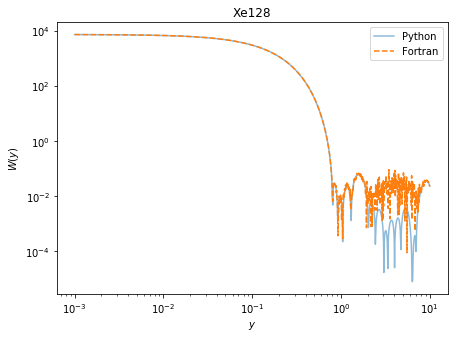

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe129 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


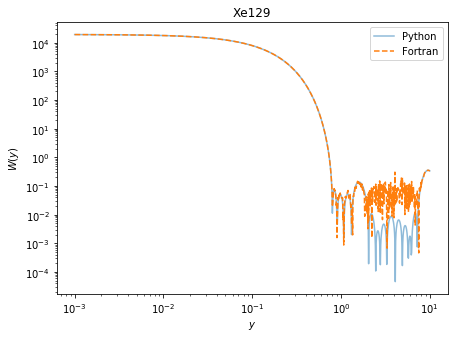

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe130 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


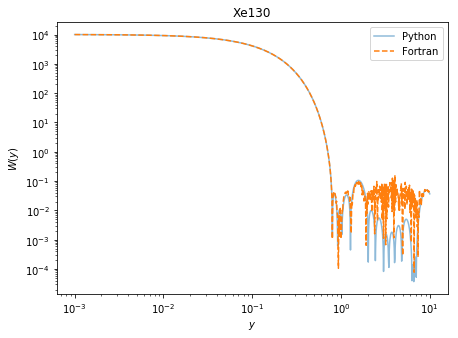

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe131 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


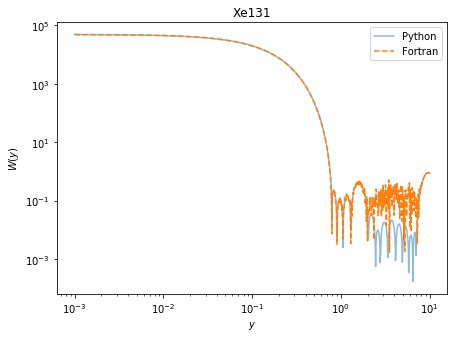

   Discrepancy found in  calcWS1  for i =  0 , j =  0


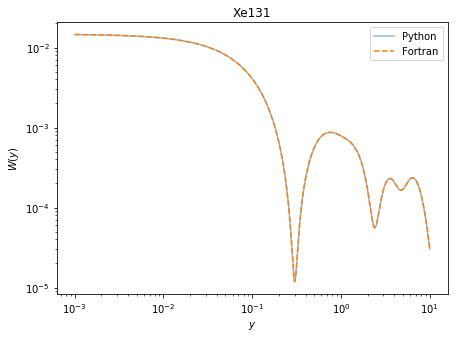

   Discrepancy found in  calcWS1  for i =  0 , j =  1


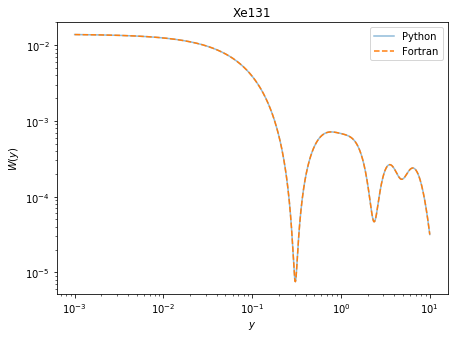

   Discrepancy found in  calcWS1  for i =  1 , j =  0


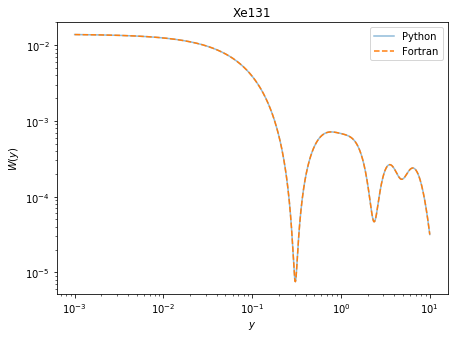

   Discrepancy found in  calcWS1  for i =  1 , j =  1


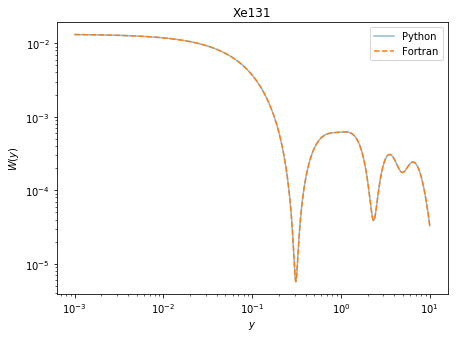

   Discrepancy found in  calcWS1D  for i =  1 , j =  0


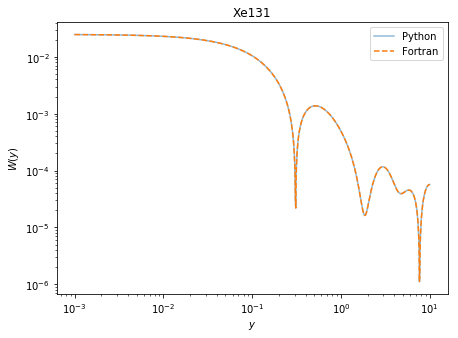

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe132 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


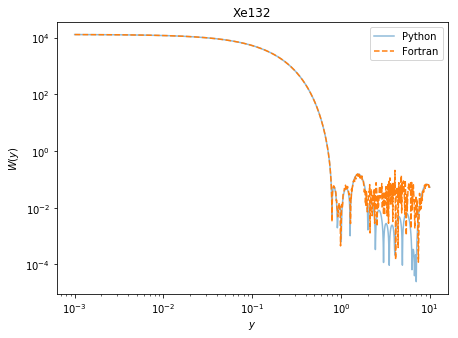

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe134 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


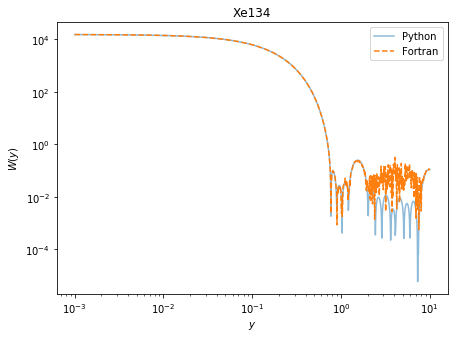

   Some discrepancies found!
 
   Testing python and fortran W functions for target Xe136 ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


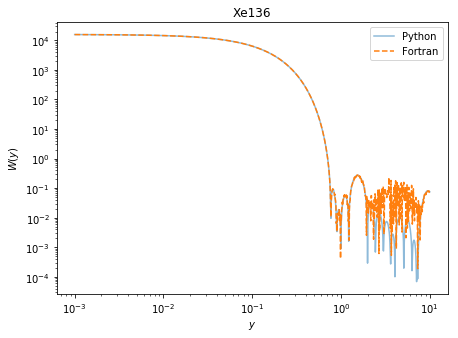

   Some discrepancies found!
 
   Testing python and fortran W functions for target Ge70 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge72 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge73 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge74 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Ge76 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Na23 ...
   No discrepancies found!
 
   Testing python and fortran W functions for target Iodine ...
   Discrepancy found in  calcWMP2  for i =  1 , j =  0


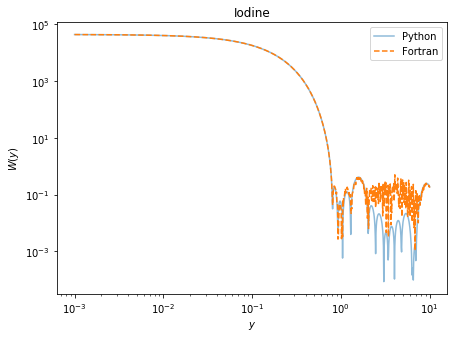

   Discrepancy found in  calcWS1D  for i =  1 , j =  0


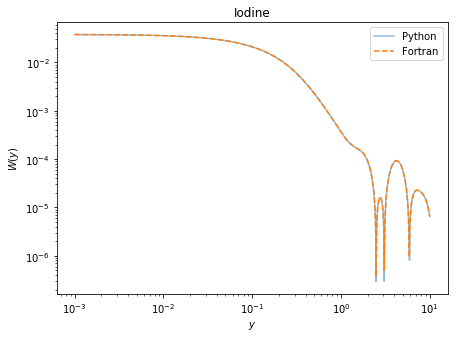

   Some discrepancies found!
 
   Testing python and fortran W functions for target Fluorine ...
   No discrepancies found!
 


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1]

In [32]:
full_target_list = ['Ni59','Ni58','Fe56','Ca40','Ar40','S32','Si28',
                    'Al27','Mg24','Ne20','O16','N14','C12','He4',
                    'He3','H','Xe128','Xe129','Xe130','Xe131','Xe132',
                    'Xe134','Xe136','Ge70','Ge72','Ge73','Ge74','Ge76',
                    'Na23','Iodine','Fluorine']

[Compare_W_y(target, err_tol=1e-4) for target in full_target_list]